In [48]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read, write
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian


# PARAMS
window_length = 400
window_step = 10
gaussian_std = 50  # standard deviation for Gaussian window in samples
gaussian_window = window_step*10
window_function = gaussian(gaussian_window, std=gaussian_std, sym=True)  # symmetric Gaussian window

# Set the thresholds 
probability_threshold = 0.5
magnitude_threshold = 0.05


def read_raw_y(file_path):
    if not os.path.isfile(file_path): 
        raise ValueError("Input file is wrong")

    return read(file_path)


def write_wav_file(file_path, fs, y):
    write(file_path, fs, y)
      
    
def identify_and_mark_noisy_frequencies(magnitudes, probability_threshold, magnitude_threshold):
    """
    Identifies and marks frequencies for denoising based on probability and magnitude thresholds.

    Parameters:
    - magnitudes (numpy.ndarray): 2D array representing the magnitudes of frequencies over time.
    - probability_threshold (float): Threshold for probability of exceeding the magnitude threshold.
    - magnitude_threshold (float): Threshold for magnitude to consider frequencies as noisy.

    Returns:
    - mean_magnitudes (numpy.ndarray): Array containing mean magnitudes of frequencies marked for denoising.
    """
    # Get the shape of the magnitudes array
    t, f = magnitudes.shape

    # Compute the maximum magnitude in the entire array
    max_magnitude = np.max(np.abs(magnitudes))

    # Compute the probability that the magnitude exceeds the specified threshold
    probabilities = np.mean(np.abs(magnitudes) > magnitude_threshold * max_magnitude, axis=0)

    # Create an indicator array based on the probability threshold
    indicator_array = np.zeros(f, dtype=int)
    indicator_array[probabilities > probability_threshold] = 1

    # Calculate the mean magnitudes for frequencies exceeding the probability threshold
    mean_magnitudes = np.zeros(f)
    mean_magnitudes[indicator_array == 1] = np.mean(np.abs(magnitudes)[:, indicator_array == 1], axis=0)

    return mean_magnitudes



def reduce_amplitude(frequency_component, reduction):
    magnitude = np.abs(frequency_component)
    phase = np.angle(frequency_component)
    
    reduced_magnitude = max(magnitude - reduction,0)
    reduced_frequency_component = reduced_magnitude * np.exp(1j * phase)

    return reduced_frequency_component


def reduce_stft_amplitudes(stft, magnitudes_to_reduce):
    new_stft = stft.copy()
    for i in range(new_stft.shape[1]):
        for j, magnitude in np.ndenumerate(magnitudes_to_reduce):
            if magnitude == 0:
                continue
            new_stft[j][i] = reduce_amplitude(new_stft[j][i], magnitude)
    return new_stft


def q1(audio_path) -> np.array:
    """
    :param audio_path: path to q1 audio file
    :return: return q1 denoised version
    """
    (fs, signal) = read_raw_y(audio_path)
    SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
    stft = SFT.stft(signal)    
    magnitudes_to_reduce = identify_and_mark_noisy_frequencies(stft.T, probability_threshold, magnitude_threshold)
    new_stft = reduce_stft_amplitudes(stft, magnitudes_to_reduce)
    return SFT.istft(new_stft, k1=len(signal))

#q2 params
(min_sec, max_sec, min_frequency, max_frequency) = (1.4, 4.2, 565, 645)

def calculate_slice_index(SFT, sec):
    return math.floor(sec / SFT.delta_t)

def calculate_slice_frequency(SFT, frequency):
    return math.floor(frequency / SFT.delta_f)

def remove_rectangle(SFT, stft, min_sec, max_sec, min_frequency, max_frequency):
    start_t = calculate_slice_index(SFT, min_sec)
    end_t = calculate_slice_index(SFT, max_sec)
    min_f = calculate_slice_frequency(SFT, min_frequency)
    max_f = calculate_slice_frequency(SFT, max_frequency)
    new_stft = stft.copy()
    new_stft.T[start_t:end_t,min_f:max_f] = 0
    return new_stft


def q2(audio_path) -> np.array:
    """
    :param audio_path: path to q1 audio file
    :return: return q2 denoised version
    """
    (fs, signal) = read_raw_y(audio_path)
    SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
    stft = SFT.stft(signal)
    new_stft = remove_rectangle(SFT, stft, min_sec, max_sec, min_frequency, max_frequency)
    return SFT.istft(new_stft, k1=len(signal))




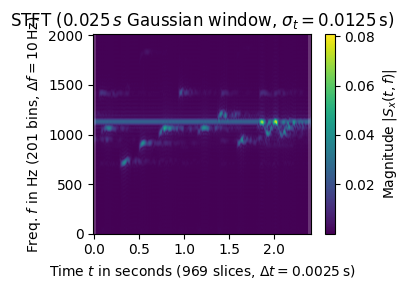

In [50]:
# q1 histograms

q1_path = './assets2/q1.wav'
(fs, signal) = read_raw_y(q1_path)
N = len(signal)
SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
stft = SFT.stft(signal)
indicator_array = identify_and_mark_noisy_frequencies(stft.T, probability_threshold, magnitude_threshold)
new_stft = reduce_stft_amplitudes(stft, indicator_array)


fig1, ax1 = plt.subplots(figsize=(4., 3.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))



im1 = ax1.imshow(abs(stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

fig1.tight_layout()
plt.show()


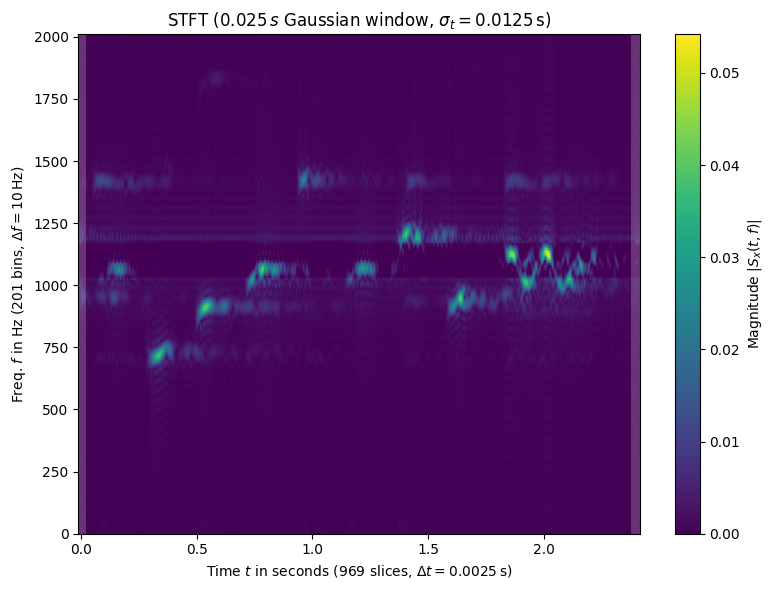

In [64]:
fig1, ax1 = plt.subplots(figsize=(8., 6.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(new_stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

fig1.tight_layout()
plt.show()

In [10]:
new_q1_signal = q1(q1_path)
write_wav_file('./assets2/new_q1_signal.wav', fs, new_q1_signal)

In [ ]:
#creating plot of different histograms

In [13]:
def get_time_vector(signal):
    signal_len = len(signal)
    return np.linspace(0, signal_len / fs, signal_len, endpoint=False)


def get_dft(signal):
    return np.fft.fft(signal)


def get_dft_and_frequencies(signal, fs):
    return np.fft.fft(signal), np.fft.fftfreq(len(signal), 1 / fs)


def get_signal(dft):
    return np.fft.ifft(dft)


def get_windows_dft_and_frequency(signal, fs, window_size, window_step):
    signal_length = len(signal)
    num_windows = (signal_length - window_size) // window_step + 1

    dfts = np.empty((num_windows, window_size), dtype=np.complex128)  # 2D array for DFT results
    indexes = []  # List to store indexes for each DFT
    frequency = np.fft.fftfreq(window_size, 1 / fs)

    for i in range(num_windows):
        start_idx = i * window_step
        end_idx = start_idx + window_size

        window = signal[start_idx:end_idx]
        dft_result, _ = get_dft_and_frequencies(window, fs)
        dfts[i, :] = dft_result  # Store the DFT result in the 2D array

        # Calculate the indexes in the original signal
        window_indexes = np.arange(start_idx, end_idx)
        indexes.append(window_indexes)

    return dfts, indexes, frequency


def get_frequencies_that_exists_in_all_windows(windows_dfts, frequency, min_amplitude):
    all_arrays = np.array(windows_dfts)
    condition_array = np.greater(np.abs(all_arrays), min_amplitude)
    result_array = np.all(condition_array, axis=0).astype(int)
    return frequency[np.argwhere(result_array > 0)]


def get_frequency_range_to_filter(frequencies_to_filter, extra_filter):
    positive_frequencies = frequencies_to_filter[frequencies_to_filter > 0]
    return np.max(np.min(positive_frequencies) - extra_filter, 0), np.max(positive_frequencies) + extra_filter


def get_filtered_signal_dft(signal_dft, frequency, frequency_range_to_filter):
    signal_dft[np.logical_and(frequency_range_to_filter[0] < np.abs(frequency),
                              np.abs(frequency) < frequency_range_to_filter[1])] = 0
    return signal_dft


def triangle_weighted_dfts_by_index(dfts, indexes):
    # Ensure the input arrays have the same length
    if len(dfts) != len(indexes):
        raise ValueError("The number of DFTs and indexes must be the same.")

    # Find the maximum index to determine the size of the 2D array
    max_index = np.max([np.max(idx) for idx in indexes])

    # Create a 2D array filled with zeros
    weighted_array = np.zeros((max_index + 1, len(dfts[0])), dtype=np.complex128)
    normalization_factors = np.zeros(max_index + 1)

    # Populate the array with triangle-weighted DFTs for each index
    for dft, index in zip(dfts, indexes):
        center = (index[0] + index[-1]) / 2  # Calculate the center index of the window
        distance_to_center = np.abs(index - center)
        weights = 1 - distance_to_center / (len(index) / 2)  # Triangle weighting

        weighted_array[index, :] += dft * weights[:, np.newaxis]
        normalization_factors[index] += weights

    # Normalize the result for each index separately
    weighted_array /= normalization_factors[:, np.newaxis]

    return weighted_array

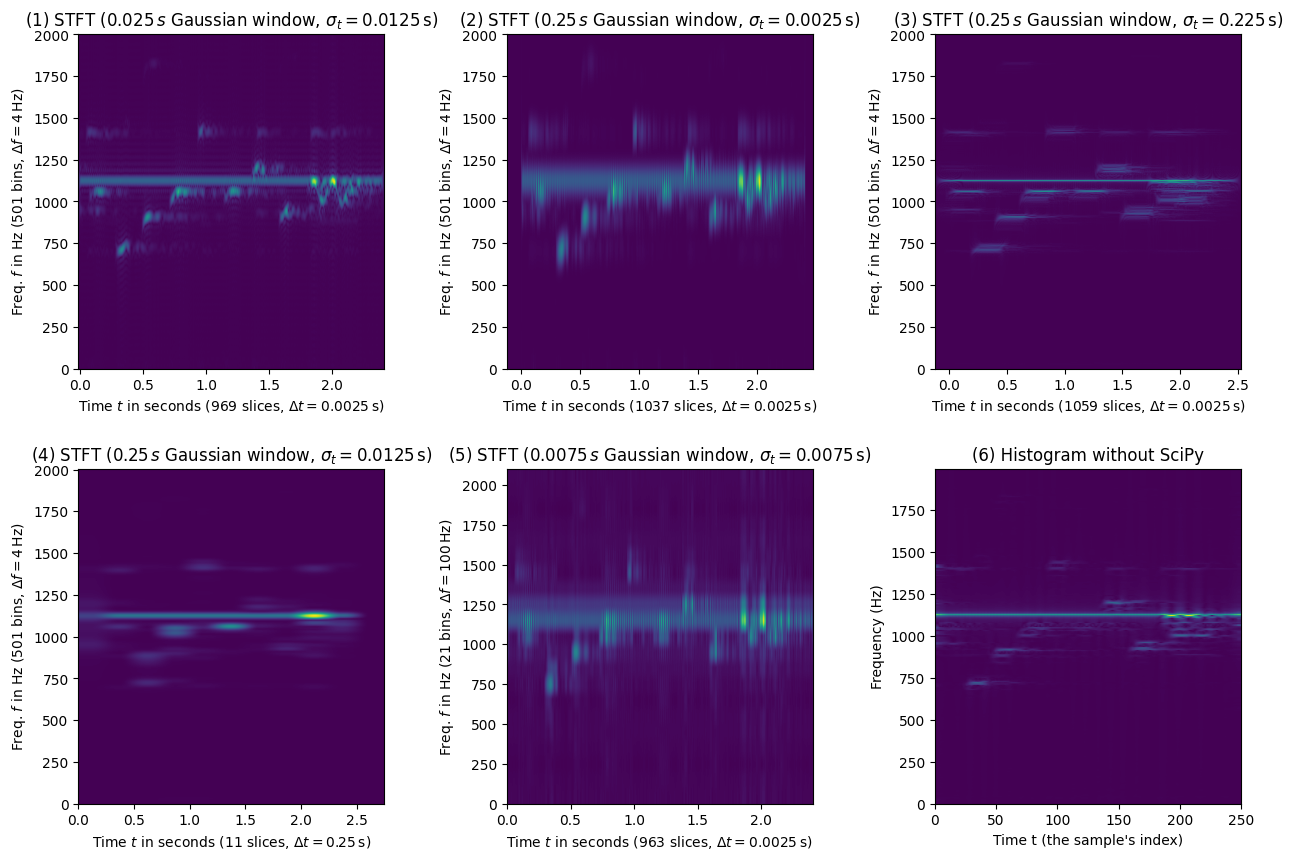

In [45]:
figs, axs = plt.subplots(2, 3, figsize=(10, 10))


q1_path = './assets2/q1.wav'
(fs, signal) = read_raw_y(q1_path)
N = len(signal)


# scipy fig with good params

window_step = 10
window_length = 1000
gaussian_std = 50  # standard deviation for Gaussian window in samples
gaussian_window = 100
window_function = gaussian(gaussian_window, std=gaussian_std, sym=True)  # symmetric Gaussian window
SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
stft = SFT.stft(signal)


plt.subplot(2, 3, 1)  # 1 row, 2 columns, first subplot
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
axs[0,0].set_title(rf"(1) STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
axs[0,0].set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))


figs.set_size_inches(15, 10)
plt.imshow(abs(stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')



# scipy fig of too small and large gaussian_std

window_step = 10
window_length = 1000
gaussian_std = 10  # standard deviation for Gaussian window in samples
gaussian_window = 1000
window_function = gaussian(gaussian_window, std=gaussian_std, sym=True)  # symmetric Gaussian window
SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
stft = SFT.stft(signal)


plt.subplot(2, 3, 2)  # 1 row, 2 columns, first subplot
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
axs[0,1].set_title(rf"(2) STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
axs[0,1].set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))


figs.set_size_inches(15, 10)
plt.imshow(abs(stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')


############################################################################################################

window_step = 10
window_length = 1000
gaussian_std = 900  # standard deviation for Gaussian window in samples
gaussian_window = 1000
window_function = gaussian(gaussian_window, std=gaussian_std, sym=True)  # symmetric Gaussian window
SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
stft = SFT.stft(signal)


plt.subplot(2, 3, 3)  # 1 row, 2 columns, first subplot
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
axs[0,2].set_title(rf"(3) STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
axs[0,2].set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))


figs.set_size_inches(15, 10)
plt.imshow(abs(stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')







# scipy fig with too big window_step

window_step = 1000
window_length = 1000
gaussian_std = 50  # standard deviation for Gaussian window in samples
gaussian_window = 1000
window_function = gaussian(gaussian_window, std=gaussian_std, sym=True)  # symmetric Gaussian window
SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
stft = SFT.stft(signal)


plt.subplot(2, 3, 4)  # 1 row, 2 columns, first subplot
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
axs[1,0].set_title(rf"(4) STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
axs[1,0].set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))


figs.set_size_inches(15, 10)
plt.imshow(abs(stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')


# scipy fig with too small window_length


window_step = 10
window_length = 40
gaussian_std = 30  # standard deviation for Gaussian window in samples
gaussian_window = 30
window_function = gaussian(gaussian_window, std=gaussian_std, sym=True)  # symmetric Gaussian window
SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
stft = SFT.stft(signal)


plt.subplot(2, 3, 5)  # 1 row, 2 columns, first subplot
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
axs[1,1].set_title(rf"(5) STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
axs[1,1].set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))


figs.set_size_inches(15, 10)
plt.imshow(abs(stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')


# my fig without using Scipy
(fs, signal) = read_raw_y('./assets/q1.wav')
signal_dft, frequency = get_dft_and_frequencies(signal, fs)
window_size = 500
window_step = 100
windows_dfts, windows_indices, windows_frequency = get_windows_dft_and_frequency(signal, fs, window_size=window_size, window_step=window_step)
weighted_dft = triangle_weighted_dfts_by_index(windows_dfts, windows_indices)


windows_dfts_for_im = np.abs(weighted_dft[:,:math.ceil(len(weighted_dft[0])/2) ])
windows_frequency_pos = windows_frequency[:math.ceil(len(windows_frequency) / 2)]
windows_dfts_for_im_rot = np.rot90(windows_dfts_for_im)

plt.subplot(2, 3, 6)  # 1 row, 2 columns, first subplot
plt.imshow(windows_dfts_for_im_rot, cmap='viridis', origin='lower', aspect='auto', extent=[0, len(windows_dfts_for_im_transposed[0]), windows_frequency_pos[-1], windows_frequency_pos[0]])


plt.title('(6) Histogram without SciPy')
plt.xlabel('Time t (the sample\'s index)')
plt.ylabel('Frequency (Hz)')
plt.gca().invert_yaxis()
# plt.gca().set_aspect( 100/ (len(windows_dfts_for_im_transposed[0]) / len(windows_frequency_pos  )))



plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()




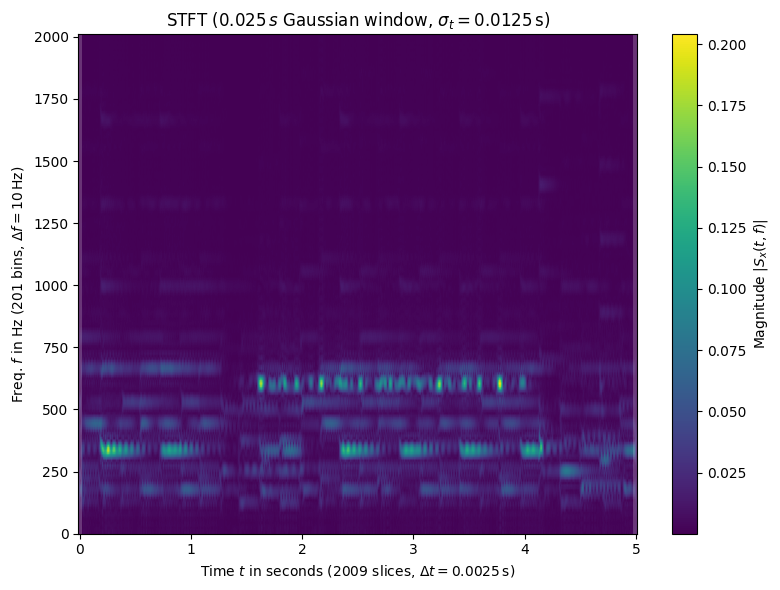

In [73]:
# q2

q2_path = './assets2/q2.wav'
(fs, signal) = read_raw_y(q2_path)
N = len(signal)
SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
stft = SFT.stft(signal)
indicator_array = identify_and_mark_noisy_frequencies(stft.T, probability_threshold, magnitude_threshold)

fig1, ax1 = plt.subplots(figsize=(8., 6.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))



im1 = ax1.imshow(abs(stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

fig1.tight_layout()
plt.show()


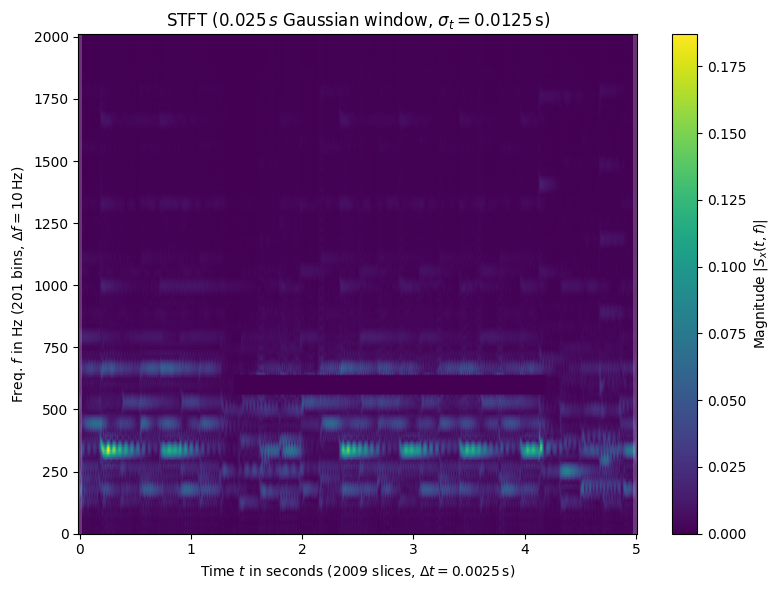

In [75]:
(min_sec, max_sec, min_frequency, max_frequency) = (1.4, 4.2, 565, 645)

SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')

fig1, ax1 = plt.subplots(figsize=(8., 6.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))


new_stft = remove_rectangle(SFT, stft, min_sec, max_sec, min_frequency, max_frequency)
im1 = ax1.imshow(abs(new_stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

fig1.tight_layout()
plt.show()


In [61]:

new_q2_signal = q2(q2_path)
write_wav_file('./assets2/new_q2_signal.wav', fs, new_q2_signal)

In [18]:
fs 

4000

In [226]:
# window_length * 750 / 2 / 2000 
# N * 1 / 2.5 / window_step 

384.0

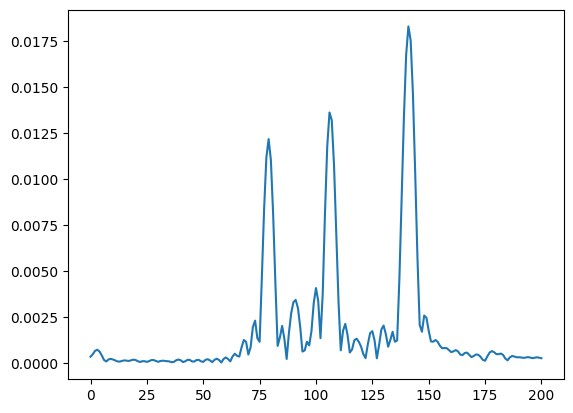

In [227]:
# plt.plot(np.abs(stft[75]))
plt.plot(np.abs(stft.T[384]))


In [ ]:


SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
fig1, ax1 = plt.subplots(figsize=(10., 8.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))


# im1 = ax1.imshow(abs(stft), origin='lower', aspect='auto',
#                  extent=SFT.extent(N), cmap='viridis')
im1 = ax1.imshow(abs(stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

fig1.tight_layout()
plt.show()